# Credit Card Transaction Fraud Detection

At times, there might be a need to assure our parents or grandparents that conducting online transactions with their credit cards is secure. Despite the reassurance, credit card numbers can be compromised, leading to instances of fraud, both in online and offline scenarios.

Once these details are illicitly obtained, unauthorized transactions become a real concern. Therefore, it becomes crucial to implement effective fraud detection mechanisms to identify and prevent such fraudulent activities.

This notebook explores the utilization of a hybrid engine, employing a combination of business rules and advanced deep learning models. The goal is to proactively detect potential fraud early in the transaction process, offering a robust defense against unauthorized activities.

Now, let's examine a set of sample transaction data for a customer to better understand these detection methods.

This project was reproduced using our own models.

In [22]:
import pandas as pd
from IPython.display import display

# Load the credit card transaction data from the CSV file
file_path = 'Artificial-Intelligence-for-Banking-master/99_sample_data/creditcarddata.csv'
sample_data = pd.read_csv(file_path)

# Filter the data for a specific account number (7476440)
account_number = 7476440
sample_data_cust = sample_data[sample_data['AccountNo'] == account_number]

# Display the first few rows of the filtered data using display
print("First few rows of the data")
display(sample_data.head())


First few rows of the data


,Gender,Age,HouseTypeID,ContactAvaliabilityID,HomeCountry,AccountNo,CardExpiryDate,TransactionAmount,TransactionCountry,LargePurchase,ProductID,CIF,TransactionCurrencyCode,PotentialFraud
0,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
1,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
2,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
3,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
4,0,56,1,0,1,1109976,1811,1.0354,1,0,3,11020290,1,0


In [12]:
# Exploratory Data Analysis (EDA)
# Check for class imbalance in the 'PotentialFraud' column
fraud_percentage = (sample_data['PotentialFraud'].value_counts(normalize=True)) * 100

# Display the percentage of fraud and non-fraud transactions
print("\nPercentage of Potential Fraud (1) and Non-Fraud (0) transactions:")
print(fraud_percentage)


Percentage of Potential Fraud (1) and Non-Fraud (0) transactions:
PotentialFraud
0    88.834951
1    11.165049
Name: proportion, dtype: float64


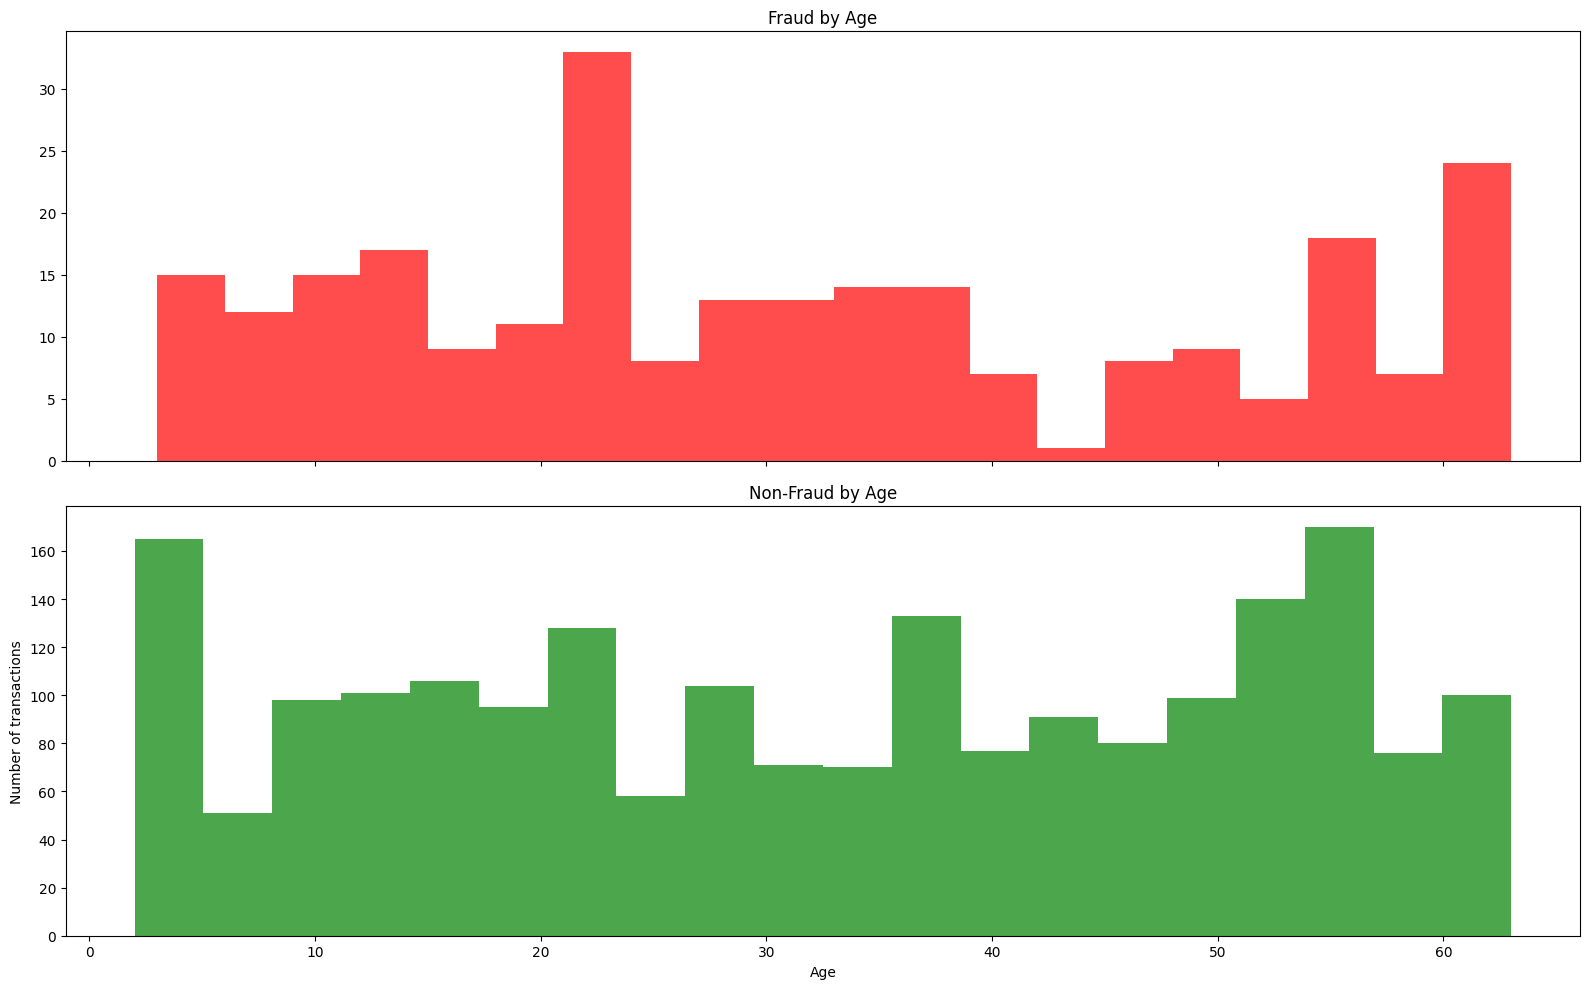

In [15]:
import matplotlib.pyplot as plt

# Create subplots with wider spacing
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))

# Plot histogram for Fraud by Age
ax1.hist(sample_data.Age[sample_data.PotentialFraud == 1], bins=20, color='red', alpha=0.7)
ax1.set_title('Fraud by Age')

# Plot histogram for Non-Fraud by Age
ax2.hist(sample_data.Age[sample_data.PotentialFraud == 0], bins=20, color='green', alpha=0.7)
ax2.set_title('Non-Fraud by Age')

# Set common x-axis label
plt.xlabel('Age')

# Set common y-axis label
plt.ylabel('Number of transactions')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [20]:
import geopy.distance
from datetime import datetime
import json

# Coordinates of two transaction locations
coords_1 = (1.3521, 103.8198)  # Transaction in Singapore
coords_2 = (20.5937, 78.9629)  # Transaction in India
coords = [coords_1, coords_2]

# Calculate the distance between the two transaction locations
distance_cur_prev_trans = geopy.distance.distance(coords_1, coords_2).km
print("Distance between the countries = " + str(distance_cur_prev_trans) + " km")

# Define the time format
f = '%Y-%m-%d %H:%M:%S'

# Transaction timestamps
prev_trans_dt = '2017-09-28 15:24:01'  # Transaction in Singapore
trans_dt = '2017-09-28 16:24:01'  # Transaction in India

# Convert timestamps to datetime objects
trans_dt = datetime.strptime(trans_dt, f)
prev_trans_dt = datetime.strptime(prev_trans_dt, f)

# Calculate the time difference between the two transactions
time_diff = trans_dt - prev_trans_dt
time_diff_mins = (time_diff.days * 86400 + time_diff.seconds) / 60
print("Time between the transactions = " + str(time_diff_mins) + " mins")

# Initialize potential fraud score and fraud reason list
potentialFraud = 0
fraudReason = []

# Check conditions for potential fraud
if distance_cur_prev_trans > 2000 and time_diff_mins < 100:
    potentialFraud += 0.6
    fraudReason.append('Transaction in multiple countries in a short duration')

# Creating the JSON object to return
final_fraud_json = {
    'potentialFraud': potentialFraud,
    'fraudReason': fraudReason
}

# Convert the dictionary to a JSON-formatted string
final_fraud_json_str = json.dumps(final_fraud_json, indent=2)  # indent for better readability

# Print the fraud reasons
print("Fraud Reasons ===>")
print(final_fraud_json_str)


Distance between the countries = 3439.5204333771308 km
Time between the transactions = 60.0 mins
Fraud Reasons ===>
{
  "potentialFraud": 0.6,
  "fraudReason": [
    "Transaction in multiple countries in a short duration"
  ]
}


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the data
data = sample_data

# Drop unnecessary columns (e.g., AccountNo, CardExpiryDate) for simplicity
data = data.drop(['AccountNo', 'CardExpiryDate'], axis=1)

# Separate features and target variable
X = data.drop('PotentialFraud', axis=1)
y = data['PotentialFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling class imbalance using SMOTE and RandomUnderSampler
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Build a simple Dense Neural Network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weight for class 1 based on your preference

# Train the model with class weights
model.fit(X_train_scaled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluate the model on the test set
y_pred_probs = model.predict(X_test_scaled)
threshold = 0.5  # You can adjust the threshold based on your preference
y_pred = (y_pred_probs > threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:\n", roc_auc_score(y_test, y_pred_probs))


Epoch 1/10
61/61 [==============================] - 3s 15ms/step - loss: 1.4247 - accuracy: 0.3696 - val_loss: 0.3006 - val_accuracy: 0.9938
Epoch 2/10
61/61 [==============================] - 1s 11ms/step - loss: 1.2067 - accuracy: 0.4798 - val_loss: 0.2921 - val_accuracy: 0.9689
Epoch 3/10
61/61 [==============================] - 1s 11ms/step - loss: 1.1547 - accuracy: 0.5150 - val_loss: 0.2554 - val_accuracy: 0.9772
Epoch 4/10
61/61 [==============================] - 1s 11ms/step - loss: 1.1300 - accuracy: 0.5352 - val_loss: 0.2381 - val_accuracy: 0.9648
Epoch 5/10
61/61 [==============================] - 1s 11ms/step - loss: 1.1127 - accuracy: 0.5497 - val_loss: 0.2478 - val_accuracy: 0.9441
Epoch 6/10
61/61 [==============================] - 1s 10ms/step - loss: 1.0976 - accuracy: 0.5481 - val_loss: 0.2441 - val_accuracy: 0.9524
Epoch 7/10
61/61 [==============================] - 1s 10ms/step - loss: 1.0860 - accuracy: 0.5699 - val_loss: 0.2437 - val_accuracy: 0.9482
Epoch 8/10
61

In [36]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_resampled, test_size=0.2, random_state=42)

# Define the model function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='credit_card_fraud'
)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)


Trial 5 Complete [00h 00m 06s]
val_accuracy: 0.6873705983161926

Best val_accuracy So Far: 0.7805383205413818
Total elapsed time: 00h 00m 25s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000024E3A3B0690>


In [37]:
# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model on the entire training dataset
final_model.fit(X_train_scaled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
61/61 [==============================] - 2s 5ms/step - loss: 0.4065 - accuracy: 0.8302 - val_loss: 1.3298 - val_accuracy: 0.0000e+00
Epoch 2/10
61/61 [==============================] - 1s 9ms/step - loss: 0.3681 - accuracy: 0.8323 - val_loss: 1.2182 - val_accuracy: 0.0559
Epoch 3/10
61/61 [==============================] - 0s 4ms/step - loss: 0.3625 - accuracy: 0.8307 - val_loss: 1.5438 - val_accuracy: 0.0000e+00
Epoch 4/10
61/61 [==============================] - 0s 7ms/step - loss: 0.3596 - accuracy: 0.8297 - val_loss: 1.0800 - val_accuracy: 0.1553
Epoch 5/10
61/61 [==============================] - 0s 8ms/step - loss: 0.3560 - accuracy: 0.8375 - val_loss: 1.3261 - val_accuracy: 0.0807
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3567 - accuracy: 0.8333 - val_loss: 1.3398 - val_accuracy: 0.0000e+00
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8385 - val_loss: 1.2148 - val_accuracy: 0.1429
Epoch 8/

In [40]:
sample_pred_data = pd.read_csv('Artificial-Intelligence-for-Banking-master/99_sample_data/creditcarddata.csv')

# Assuming your training data has 11 features, adjust this accordingly
# Make sure to preprocess sample_pred_data in the same way you preprocessed your training data
# (scaling, handling missing values, etc.)

# Example: Assuming your training data has 11 features
sample_pred_data = sample_pred_data.drop(['AccountNo', 'CardExpiryDate'], axis=1)  # Drop unnecessary columns
sample_pred_data = sample_pred_data.iloc[:, 0:11]  # Assuming your data has 11 features
# Ensure any additional preprocessing steps are applied as needed

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model on the entire training dataset
final_model.fit(X_train_scaled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

# Assuming sample_pred_data is your input data
# Ensure it is preprocessed in the same way as your training data (scaled, etc.)
# For demonstration purposes, you may need to preprocess it accordingly.

# Make a prediction
predictions = final_model.predict(sample_pred_data)

# Assuming you have a threshold for classification, e.g., 0.5
threshold = 0.5
fraud_probability = predictions[0][0]

# Make a binary decision based on the threshold
potential_fraud = 1 if fraud_probability > threshold else 0

print("Potential Fraud? : {}".format(potential_fraud))


Epoch 1/10
61/61 [==============================] - 2s 9ms/step - loss: 0.4017 - accuracy: 0.8225 - val_loss: 1.2126 - val_accuracy: 0.0663
Epoch 2/10
61/61 [==============================] - 0s 8ms/step - loss: 0.3687 - accuracy: 0.8328 - val_loss: 1.2076 - val_accuracy: 0.1222
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8344 - val_loss: 1.2727 - val_accuracy: 0.0186
Epoch 4/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.8339 - val_loss: 1.3237 - val_accuracy: 0.1118
Epoch 5/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3514 - accuracy: 0.8339 - val_loss: 1.2331 - val_accuracy: 0.1573
Epoch 6/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3532 - accuracy: 0.8344 - val_loss: 1.1097 - val_accuracy: 0.1636
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3471 - accuracy: 0.8375 - val_loss: 0.8615 - val_accuracy: 0.4783
Epoch 8/10
61/61 [==

The scoring model showcased above effectively demonstrates the capability to utilize both a trained model and rule-based systems for assessing potential fraud in customer transactions. By combining these two approaches, we can derive a comprehensive evaluation of potential fraud, enabling real-time transaction flagging and appropriate actions.

# Conclusion

In conclusion, the fusion of rule-based systems and advanced deep learning models is paramount for robust credit card fraud detection. This hybrid approach leverages the strengths of both methodologies, drawing insights from extensive historical customer transactions to proactively identify and prevent unwanted activities.